In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Caminho para os dados no Google Drive
file_path_real = '/content/drive/MyDrive/audios_FOR/real'
file_path_fake = '/content/drive/MyDrive/audios_FOR/fake'

In [ ]:
# Função para extrair MFCCs de um arquivo
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return np.mean(mfccs.T, axis=0)  # Média dos coeficientes
    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return None

# Carregar dados e rótulos
data = []
labels = []

In [ ]:
def load_data(folder_path, label):
    global data, labels
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        features = extract_features(file_path)
        if features is not None:
            data.append(features)
            labels.append(label)

# Criar as pastas 'real' e 'fake' caso não existam
if not os.path.exists(file_path_real):
    os.makedirs(file_path_real)
if not os.path.exists(file_path_fake):
    os.makedirs(file_path_fake)

# Processar dados
load_data(file_path_fake, 0)  # Rótulo 0 para Fake
load_data(file_path_real, 1)  # Rótulo 1 para Real

In [ ]:
# Remover dados faltantes
data_filtered = []
labels_filtered = []
for i in range(len(data)):
    if data[i] is not None:
        data_filtered.append(data[i])
        labels_filtered.append(labels[i])

data = data_filtered
labels = labels_filtered

In [ ]:
# Bagunçando completamente os rótulos de propósito
np.random.shuffle(labels)  # Embaralha completamente os rótulos

In [ ]:
# Converter para DataFrame
df = pd.DataFrame(data)
df['label'] = labels

# Contar as ocorrências de cada label
label_counts = df['label'].value_counts()

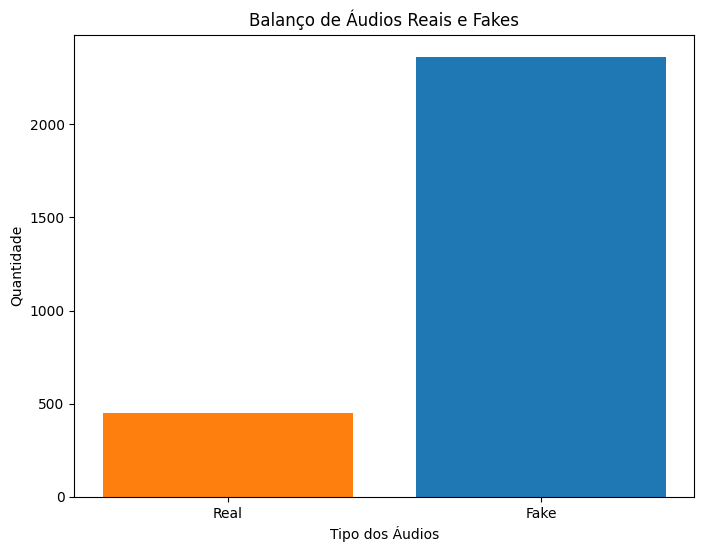

In [ ]:
# Plotando o gráfico
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, tick_label=['Fake', 'Real'], color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Tipo dos Áudios')
plt.ylabel('Quantidade')
plt.title('Balanço de Áudios Reais e Fakes')
plt.show()

In [ ]:
df.shape

(2811, 14)

In [ ]:
# Separar características (X) e rótulos (y)
X = df.drop(columns=['label'])
y = df['label']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [ ]:
# Modelos
models = {
    "XGBoost": XGBClassifier(n_estimators=10, use_label_encoder=False, eval_metric='logloss'),
    "LGBM": LGBMClassifier(n_estimators=10),
    "RandomForest": RandomForestClassifier(n_estimators=10, max_depth=3),
    "SVM": SVC(kernel='linear', probability=True)
}

# Criando um modelo CNN simples
cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(13, 1)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar e avaliar modelos clássicos
for name, model in models.items():
    print(f"Treinando e avaliando {name}:")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"Acurácia: {accuracy:.2f}")
    print(f"Precisão: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("-" * 30)

# Treinando e avaliando a CNN
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)
cnn_model.fit(X_train_cnn, y_train, epochs=5, batch_size=4, verbose=1)
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred_cnn)
precision = precision_score(y_test, y_pred_cnn, zero_division=0)
recall = recall_score(y_test, y_pred_cnn, zero_division=0)
f1 = f1_score(y_test, y_pred_cnn, zero_division=0)

print("Treinando e avaliando CNN:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("-" * 30)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Treinando e avaliando XGBoost:
Acurácia: 0.84
Precisão: 0.84
Recall: 0.99
F1-Score: 0.91
------------------------------
Treinando e avaliando LGBM:
Acurácia: 0.85
Precisão: 0.85
Recall: 1.00
F1-Score: 0.92
------------------------------
Treinando e avaliando RandomForest:
Acurácia: 0.85
Precisão: 0.85
Recall: 1.00
F1-Score: 0.92
------------------------------
Treinando e avaliando SVM:
Acurácia: 0.85
Precisão: 0.85
Recall: 1.00
F1-Score: 0.92
------------------------------
Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7768 - loss: 0.7617
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8190 - loss: 0.4948
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8278 - loss: 0.4989
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8273 - loss: 0.4903
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8489 - loss: 0.4393
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Treinando e avaliando CNN:
Acurácia: 0.85
Precisão: 0.85
R